In [11]:
# import relevant libraries
import numpy as np
import h5py
import re
import glob
import os
import pathlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import datetime
from impactClass import impactClass
%matplotlib inline

In [12]:
# define method to load data from files
def loadSegmentFile(filename):
    file = open(filename, mode = 'r')
    lines = file.readlines()
    file.close()
    N = len(lines)
    gps = np.zeros([N,1])
    dur = np.zeros([N,1])
    for ii in range(0,N):
        base = os.path.basename(lines[ii])
        x = re.findall(r'g_(\d+)_(\d+).tar.gz\n',base)
        y = x.pop(0)
        gps[ii] = float(y[0])
        dur[ii] = float(y[1])
    out = {'gps' : gps, 'dur' : dur}
    return out

# define method to find large chunks
def getPlotSegs(segs,thresh=86400):
    gps = segs['gps']
    dur = segs['dur']
    gaps = np.zeros([len(gps),1])
    for ii in range(0,len(gps)-1):
        start = gps[ii]
        stop = gps[ii]+dur[ii]
        gaps[ii] = gps[ii+1]-stop
        
    bigIdx = np.where(gaps > thresh)[0]
    bigStarts = gps[np.append(0,bigIdx+1)]
    bigStops = gps[np.append(bigIdx,len(gaps)-1)]+dur[np.append(bigIdx,len(gaps)-1)]
    bigDurs = bigStops-bigStarts
    out = {'starts' : bigStarts, 'stops' : bigStops, 'length' : bigDurs, 'idx' : np.append(0,bigIdx+1)}
    return out


In [13]:
p = pathlib.PurePath(os.getcwd())
BASE_DIR = str(p.parent)
dataDir = '/data'
plotDir = '/plots'
fe = h5py.File(BASE_DIR + dataDir +'/lpfEphem.h5', 'r')

In [14]:
list(fe.keys())

['CoRotating', 'EME2000']

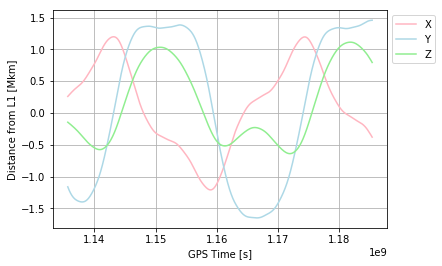

In [49]:
dataset = fe['EME2000']
dat = dataset[...]
gps = dat[0,0,...]
gpsStart =((datetime.datetime.strptime('2016-01-01','%Y-%m-%d')-datetime.datetime(1970,1,1)).total_seconds())-315964783
idxStart = np.argmin(np.abs(gpsStart-gps))
gpsStop =((datetime.datetime.strptime('2017-07-30','%Y-%m-%d')-datetime.datetime(1970,1,1)).total_seconds())-315964783
idxStop = np.argmin(np.abs(gpsStop-gps))
gps = dat[0,0,idxStart:idxStop:10]
X = dat[0,1,idxStart:idxStop:10]/1e6
Y = dat[0,2,idxStart:idxStop:10]/1e6
Z = dat[0,3,idxStart:idxStop:10]/1e6
fig,ax = plt.subplots(1)
plt.plot(gps,X,color='lightpink')
plt.plot(gps,Y,color='lightblue')
plt.plot(gps,Z,color='lightgreen')
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_xlabel('GPS Time [s]')
ax.set_ylabel('Distance from L1 [Mkm]')
plt.legend(('X','Y','Z'),loc = 'upper left',bbox_to_anchor=(1,1))

In [16]:
# load impact data
impFiles = glob.glob(BASE_DIR + dataDir + '/ONLY_IMPACTS/*_grs1.pickle')
imps = []
for idx,impFile in enumerate(impFiles):
    imp = impactClass(impFile, dataDir = dataDir, BASE_DIR = BASE_DIR)
    if imp.isImpact :
        imp.SCtoSun()
        imp.findSkyAngles()
        imps.append(imp)

print('%d impacts loaded' % len(imps))


54 impacts loaded


In [50]:
# load segment data
drs = loadSegmentFile(BASE_DIR + dataDir + '/observed_times/DRSlistDec.txt')
ltp = loadSegmentFile(BASE_DIR + dataDir + '/observed_times/LTPlist2.txt')
hybrid = loadSegmentFile(BASE_DIR + dataDir + '/observed_times/LTPCMNTlist.txt')
drsPlot = getPlotSegs(drs)
ltpPlot = getPlotSegs(ltp)
hybridPlot = getPlotSegs(hybrid)

In [51]:
xImp = np.zeros((len(imps),3))
for ii in range(0,len(imps)):
    idx = np.argmin(np.abs(gps-imps[ii].gps))
    xImp[ii,0]=X[idx]
    xImp[ii,1]=Y[idx]
    xImp[ii,2]=Z[idx]


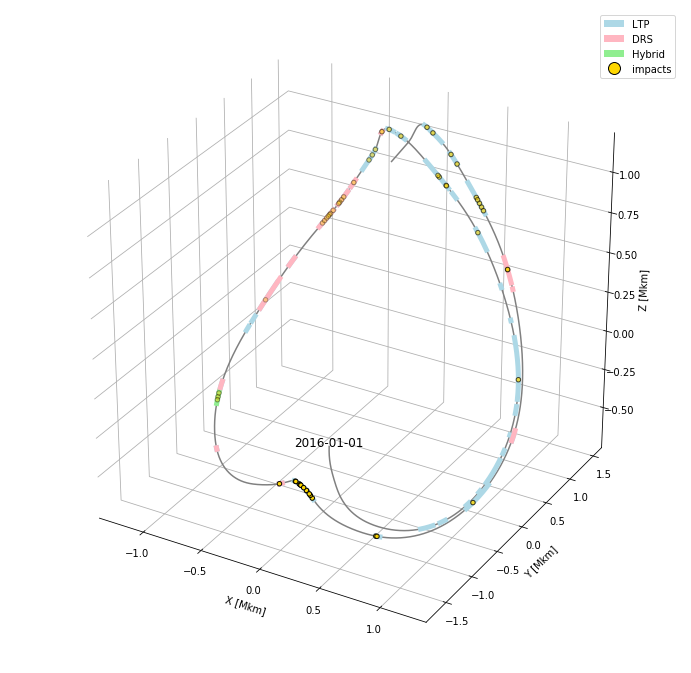

In [56]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Prepare arrays x, y, z



ax.plot(X, Y, Z, label='all',color='gray',zorder=-4)

for ii in range(0,len(ltpPlot['starts'])):
    startIdx = np.argmin(np.abs(gps-ltpPlot['starts'][ii]))
    stopIdx = np.argmin(np.abs(gps-ltpPlot['stops'][ii]))
    ax.plot(X[startIdx:stopIdx],Y[startIdx:stopIdx],Z[startIdx:stopIdx],label='LTP',color='lightblue',linewidth=5.0,zorder=-3)
    
for ii in range(0,len(drsPlot['starts'])):
    startIdx = np.argmin(np.abs(gps-drsPlot['starts'][ii]))
    stopIdx = np.argmin(np.abs(gps-drsPlot['stops'][ii]))
    ax.plot(X[startIdx:stopIdx],Y[startIdx:stopIdx],Z[startIdx:stopIdx],label='LTP',color='lightpink',linewidth=5.0,zorder=-2)
    
for ii in range(0,len(hybridPlot['starts'])):
    startIdx = np.argmin(np.abs(gps-hybridPlot['starts'][ii]))
    stopIdx = np.argmin(np.abs(gps-hybridPlot['stops'][ii]))
    ax.plot(X[startIdx:stopIdx],Y[startIdx:stopIdx],Z[startIdx:stopIdx],label='LTP',color='lightgreen',linewidth=5.0,zorder=-1)

ax.scatter(xImp[...,0], xImp[...,1], xImp[...,2], s=20,facecolor = 'gold', edgecolor='black', marker='o',zorder=0)


ax.text(X[0], Y[0], Z[0], '2016-01-01',fontsize=12,horizontalalignment='center')


ax.set_xlabel('X [Mkm]')
ax.set_ylabel('Y [Mkm]')
ax.set_zlabel('Z [Mkm]')


handles = []
handles.append(Polygon([(0,0),(10,0),(0,-10)],facecolor='lightblue',label='LTP'))
handles.append(Polygon([(0,0),(10,0),(0,-10)],facecolor='lightpink',label='DRS'))
handles.append(Polygon([(0,0),(10,0),(0,-10)],facecolor='lightgreen',label='Hybrid'))
handles.append(mlines.Line2D([], [], linestyle='none', markerfacecolor='gold', 
                             markeredgecolor = 'black',marker='o',markersize=12, label='impacts'))
#handles.append(Circle((0,0),facecolor='gold',edgecolor = 'black',label='impacts'))
plt.legend(handles = handles, loc = 'best')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.set_size_inches(12,12)
plt.show()

fig.savefig(BASE_DIR + plotDir + '/ephemeris.eps', format = 'eps',bbox_inches='tight')